In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import json

np.random.seed(0)
random.seed(0)

import warnings; warnings.filterwarnings("ignore")


In [2]:
#https://www.kaggle.com/c/nlp-getting-started/data?select=train.csv

Our project is a Kaggle competition.

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ (https://appen.com/open-source-datasets/).

We have to predict whether a given tweet is about a real disaster or not.

For that we want to apply two kind of transfer learning technics:
-features extraction
-fine-tuning

And we want to see which one is the most relevant in our case.

## Data : description and cleaning


id - a unique identifier for each tweet

text - the text of the tweet

location - the location the tweet was sent from (may be blank)

keyword - a particular keyword from the tweet (may be blank)

target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [3]:
df_train = pd.read_csv('/content/train.csv')


In [4]:
print('Shape of Train Data :', df_train.shape)


Shape of Train Data : (7613, 5)


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
dftrain = df_train.drop(['keyword', 'location', 'id'], axis=1)

## Statistcs

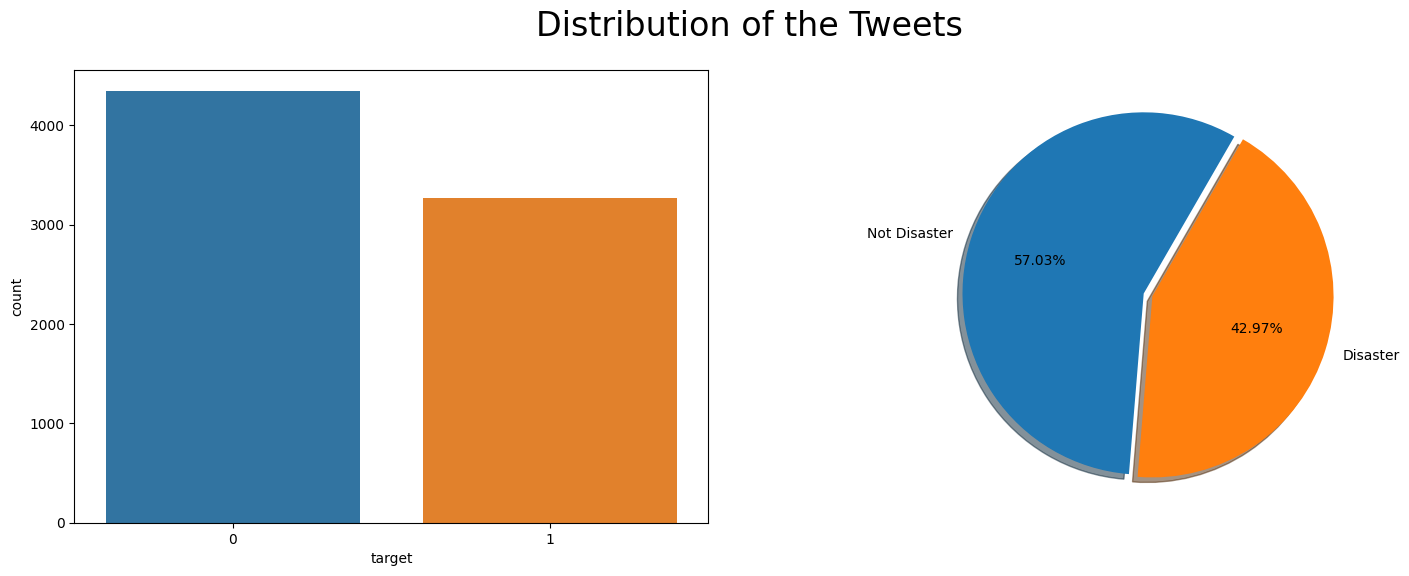

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(dftrain['target'], ax=axes[0])
axes[1].pie(dftrain['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [8]:
def plot_sent_len(dataf, col, title):
    dataf['len_' + col] = dataf[col].apply(lambda txt: len(txt.split()))
    plt.hist(dataf['len_' + col], bins = 100)
    plt.title('{} sentences length'.format("data"))
    plt.show()
    return dataf


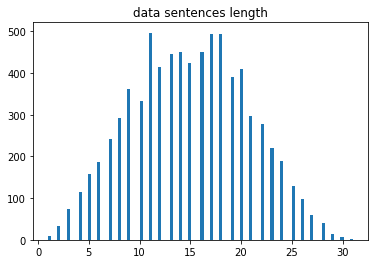

In [9]:
df = plot_sent_len(dftrain, 'text', 'sentence lengths')

Text(0.5, 0, 'Message Length')

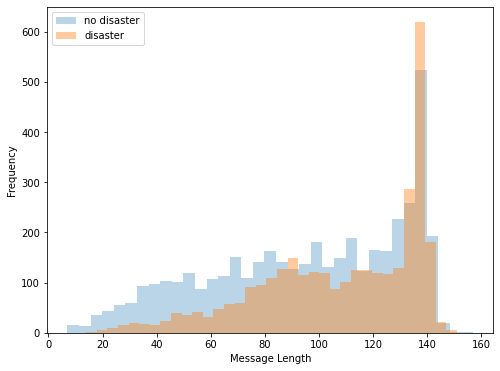

In [10]:
plt.figure(figsize=(8, 6))
dftrain.text.loc[dftrain.target==0].apply(lambda x: len(x)).plot(bins=35, kind='hist', label='no disaster', alpha=0.3)
dftrain.text.loc[dftrain.target==1].apply(lambda x: len(x)).plot(bins=35, kind='hist', label='disaster', alpha=0.4)
plt.legend()
plt.xlabel("Message Length")

Text(0.5, 0.98, 'Characters in tweets')

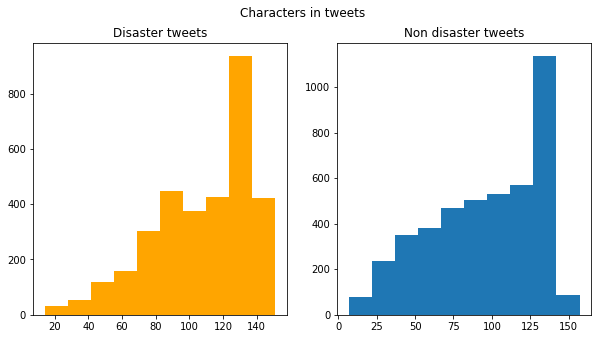

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = dftrain[dftrain['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='orange')
ax1.set_title('Disaster tweets')
tweet_len = dftrain[dftrain['target']==0]['text'].str.len()
ax2.hist(tweet_len)
ax2.set_title('Non disaster tweets')
fig.suptitle('Characters in tweets')

## CLEAING & TOKENIZATION

In [12]:
!pip install ekphrasis

In [13]:
import json
import pandas as pd
import numpy as np
import re
import nltk
#from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
#import emoji
from tqdm import tqdm
import warnings
import os
from multiprocessing import Pool
import multiprocessing
import glob
import ekphrasis

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from ekphrasis.dicts.noslang.slangdict import slangdict


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
#deal with Tweeter abreviation and replace them.
uncased_slang_dict = {}
for key, value in slangdict.items():
    value = re.sub(r'it means', '', value)
    value = re.sub(r'\*\*\*', 'uck', value)
    value = re.sub(r'\*\*', 'it', value)
    value = re.sub(r'it refers to', '', value)
    uncased_slang_dict[key.lower()] = value.lower()
#print('Slang words number:', len(uncased_slang_dict))

In [16]:
def replace_slang(txt, slang):
    ctxt = re.sub(r'\s+', ' ', txt)
    tt = []
    for tok in ctxt.split():
        if tok.lower() in slang:
            tt.append(slang[tok.lower()])
        else:
            tt.append(tok)
    tt = ' '.join(tt)
    return tt.strip()

def preprocess(txt):
    tt = txt.encode('ascii', 'ignore').decode()
    tt = replace_slang(tt, uncased_slang_dict)
    return tt.strip()

In [17]:
dftrain['clean_text']= dftrain['text'].apply(preprocess)

In [18]:
stop_words = set(stopwords.words('english'))

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

def remove_html(txt):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', txt)

def CLEAN_TOKEN(base):
      tokenizer = TweetTokenizer()
      base = base.apply(lambda x: remove_URL(x))
      base = base.apply(lambda x: remove_html(x))
      base = base.apply(lambda x: x.replace('#', ''))
      base = base.apply(lambda x: x.replace(']', ''))
      base = base.apply(lambda x: x.replace('[', ''))
      base = base.apply(lambda x: x.replace('"', ''))
      base = base.apply(lambda x: x.replace('?', ''))
      base = base.apply(lambda x: x.replace('.', ''))
      base = base.apply(lambda x: remove_stopwords(x))
      base = base.apply(tokenizer.tokenize)
      base = base.apply(lambda x: [word.lower() for word in x])
      
      return base

In [19]:
dftrain['clean_text_token']=CLEAN_TOKEN(dftrain['clean_text'])

## MODELS 1 and 2 with Distbill Bert

We first collect embendding vectors from a pre-trained version of DistilBERT (which a distil version of BERT model, https://huggingface.co/transformers/model_doc/distilbert.html).

We chose this model for computational reasons: the collection of embendding vectors can be very slow to compute.

Once we have the embedding representation of all token of the database, we select the first token of each sentence ([CLS] token) which is very usefull for classification.

We finally train a Logistic Regression and a Random Forest on this token.
We also gridsearch to find good hyperparameters.

In [20]:
!pip install transformers

In [21]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, DistilBertConfig, get_linear_schedule_with_warmup, DistilBertModel


In [22]:
if torch.cuda.is_available():    
  device = torch.device('cuda')  

In [23]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

pretrained_weights='distilbert-base-uncased'
config_class=DistilBertConfig
model_class=DistilBertModel
config = config_class.from_pretrained(pretrained_weights,output_hidden_states=True)
model = model_class.from_pretrained(pretrained_weights,config=config)


In [24]:
#we collect all token (padded) but not projected yet (each token (number) is in dimension 1)
def inputs_id_attention_mask(data):
  train_tokenized=data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = 0
  for j in train_tokenized.values:
        if len(j) > max_len:
            max_len = len(j)

  padded = np.array([k + [0]*(max_len-len(k)) for k in train_tokenized.values])
  attention_mask = np.where(padded != 0, 1, 0)


  torch_input_ids=torch.tensor(padded)
  torch_attention_mask=torch.tensor(attention_mask)

  return torch_input_ids, torch_attention_mask

torch_input_ids, torch_attention_mask = inputs_id_attention_mask(dftrain['clean_text_token'])


In [25]:
# for this method the all dataset is to heavy. So we reduce the number of sentences. We worked until 3000 and the balance of the two classes was still good.
# and we collect embeddings vectors and keep the [CLS] token (dimension : 768)
n=2000
with torch.no_grad():
    last_hidden_states=model(torch_input_ids[0:n,],torch_attention_mask[0:n,])

CLS_token=last_hidden_states[0][:,0,:].numpy()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix



In [27]:
X_train, X_test, y_train, y_test = train_test_split(CLS_token, dftrain.target[0:n], test_size=0.33, random_state=42)

In [28]:
classifiers = {'Logistic regression':LogisticRegression(random_state=0),
               'Random Forest': RandomForestClassifier(random_state=0)}

parameters_rf = {'n_estimators': [300, 600], 'max_features': ['log2', 'sqrt'], 'max_depth': [300, 700], 'min_samples_split': [500, 700]}

parameters_logit = {'max_iter': [100,200],'C': [1, 10, 100]}

pars = [parameters_logit, parameters_rf]


In [29]:
def grid_search_classifier(clf,params):
    parameters = params
    f1_scorer = make_scorer(f1_score)
    grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)
    grid_obj = grid_obj.fit(X_train, y_train)
    clf = grid_obj.best_estimator_
    return clf

def allmetrics(y_test,ypred):
    metrics = pd.DataFrame([],columns=['accuracy','recall','precision','f1-score'])
    metrics['accuracy'] = [accuracy_score(y_test,ypred)]
    metrics['recall'] = [recall_score(y_test,ypred,average='macro')]
    metrics['precision'] = [precision_score(y_test,ypred,average='macro',zero_division=0)]
    metrics['f1-score'] = [f1_score(y_test,ypred,average='macro',zero_division=0)]
    return metrics

In [30]:
clf_l = grid_search_classifier(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False),parameters_logit)
clf_l.fit(X_train,y_train)
ypred_logit = clf_l.predict(X_test)



In [31]:
clf_r = grid_search_classifier(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False),parameters_rf)
clf_r.fit(X_train,y_train)
ypred_rf = clf_r.predict(X_test)

In [32]:
#we display many metrics, but for the challenge just the f1-score is important
print('\033[1m' + "Logistic Regression" + '\033[0m')
print(allmetrics(y_test,ypred_logit))
print('\033[1m' + "Random Forest" + '\033[0m')
print(allmetrics(y_test,ypred_rf))


Logistic Regression
   accuracy    recall  precision  f1-score
0  0.783333  0.752901   0.781942  0.761184
Random Forest
   accuracy    recall  precision  f1-score
0  0.771212  0.723681   0.792943   0.73395


In [33]:
def plot_confusion_matrix(ytrue,ypred,norm=False,label_map=None):
    plt.figure(figsize=(5,5))
    labels = np.unique(ytrue)
    cm = confusion_matrix(ytrue,ypred,labels = labels)
    if norm:
        cm = np.round(cm/cm.sum(axis=0),3)
        cm = np.nan_to_num(cm)
        fmt = '.2f'
    else:
        fmt = 'd'
    if not label_map is None:
        labels = [label_map[l] for l in labels]
    #plot
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt=fmt, cmap="Reds", vmin = 0.2)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

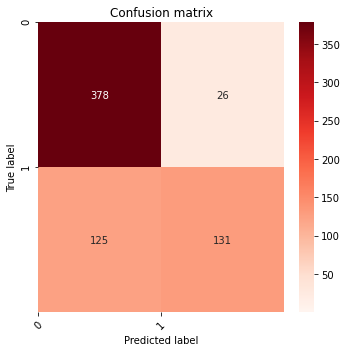

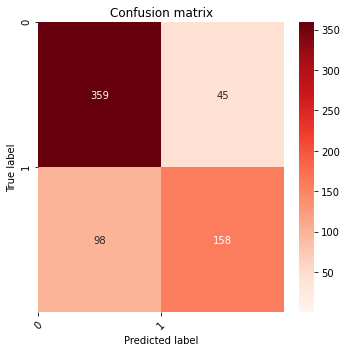

In [34]:
plot_confusion_matrix(y_test,ypred_rf,norm=False,label_map=None)
plot_confusion_matrix(y_test,ypred_logit,norm=False,label_map=None)


## DistilBERT and Fine Tuning

In this part, we fine tune a pre-trained version of DistilBert.
This is the deep learning part of our project.

In [35]:
from transformers import DistilBertModel
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


In [36]:
X_train, X_test, y_train, y_test = train_test_split(dftrain.clean_text_token[0:3000], dftrain.target[0:3000], test_size=0.33, random_state=42)


In [37]:
train_inputs, train_masks = inputs_id_attention_mask(X_train)
test_inputs, test_masks = inputs_id_attention_mask(X_test)

In [38]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.tensor(y_train.to_numpy())
test_labels = torch.tensor(y_test.to_numpy())

#batch size of 32 (according to the authors)
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [39]:
import torch
import torch.nn as nn

class DistilBertModel_classifier(nn.Module):
    def __init__(self, pretrained_model_name='distilbert-base-uncased'):
        super(DistilBertModel_classifier, self).__init__()
        D_in, H, D_out = 768, 50, 2
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

    def forward(self, input_ids, attention_mask):
  
        outputs = self.distilbert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

In [40]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):

    bert_classifier = DistilBertModel_classifier()

    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    
                      eps=1e-8 
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [41]:
import random
import time

loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, test_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:

            val_loss, val_accuracy = evaluate(model, test_dataloader)

            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training finished!")


def evaluate(model, test_dataloader):

    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [42]:
set_seed(1)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, test_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.568877   |     -      |     -     |   2.26   
   1    |   40    |   0.467442   |     -      |     -     |   2.11   
   1    |   60    |   0.509371   |     -      |     -     |   2.12   
   1    |   62    |   0.526107   |     -      |     -     |   0.20   
----------------------------------------------------------------------
   1    |    -    |   0.516427   |  0.445846  |   80.82   |   7.65   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.363353   |     -      |     -     |   2.22   
   2    |   40    |   0.374613   |     -      |     -     |   2.13   
   2    |   60    |   0.386125   |     -      |     -     |   2.1

In [43]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    all_logits = torch.cat(all_logits, dim=0)

    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    threshold = 0.8
    preds = np.where(probs[:, 1] > threshold, 1, 0)

    return preds

In [44]:
pred_DB=bert_predict(bert_classifier, test_dataloader)

In [45]:
print('\033[1m' + "Fine-Tuning" + '\033[0m')
print(allmetrics(y_test,pred_DB))

Fine-Tuning
   accuracy    recall  precision  f1-score
0   0.80101  0.762203   0.839022  0.773504


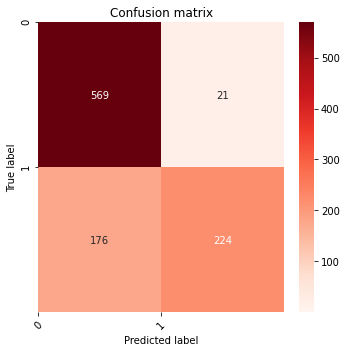

In [46]:
plot_confusion_matrix(y_test,pred_DB,norm=False,label_map=None)


We obtain results slightly better with the fine-tuning process than with the features extraction. 

The gap would be more impressive with more data and a better computationnal power.

Nethertheless the fine-tuning process is much more faster.
